In [270]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import geopandas as gpd
import os

%matplotlib inline
DATA_DIR = '/Users/lee/Documents/UCLA/Year3/CS_130/project/uber-pickups-in-new-york-city'
DATA_FILES = ['uber-raw-data-apr14.csv','uber-raw-data-aug14.csv','uber-raw-data-jul14.csv','uber-raw-data-jun14.csv','uber-raw-data-may14.csv','uber-raw-data-sep14.csv']

uber_data_list = []
for data_file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_DIR, data_file))
    uber_data_list.append(df)

uber_data = pd.concat(uber_data_list)
uber_data.head()
#829275 entries
#4534327 entries total

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [272]:
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_data['Month'] = uber_data['Date/Time'].dt.month
uber_data['Year'] = uber_data['Date/Time'].dt.year
uber_data['DayOfWeekNum'] = uber_data['Date/Time'].dt.dayofweek
uber_data['DayOfWeek'] = uber_data['Date/Time'].dt.weekday_name
uber_data['MonthDayNum'] = uber_data['Date/Time'].dt.day
uber_data['HourOfDay'] = uber_data['Date/Time'].dt.hour
uber_data['ChunkIndex'] = 4*uber_data['HourOfDay'] + uber_data['Date/Time'].dt.minute // 15 # which 15-minute block within the day is it in

uber_data.head()

,Date/Time,Lat,Lon,Base,Month,Year,DayOfWeekNum,DayOfWeek,HourOfDay,ChunkIndex,MonthDayNum
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,2014,1,Tuesday,0,0,1
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,2014,1,Tuesday,0,1,1
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,2014,1,Tuesday,0,1,1
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,2014,1,Tuesday,0,1,1
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,2014,1,Tuesday,0,2,1


In [273]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 1028135
Data columns (total 11 columns):
Date/Time       datetime64[ns]
Lat             float64
Lon             float64
Base            object
Month           int64
Year            int64
DayOfWeekNum    int64
DayOfWeek       object
HourOfDay       int64
ChunkIndex      int64
MonthDayNum     int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 415.1+ MB


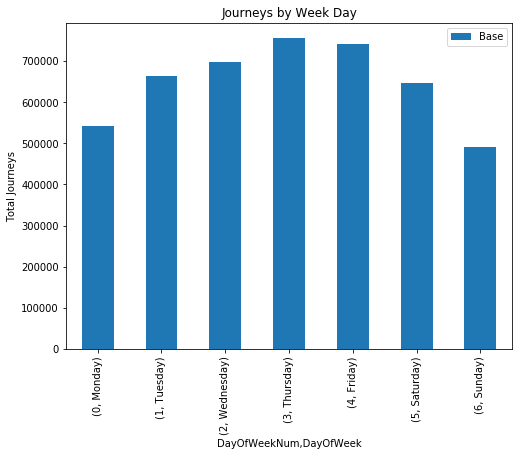

In [274]:
uber_weekdays = uber_data.pivot_table(index=['DayOfWeekNum', 'DayOfWeek'],
                                  values='Base',
                                  aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Week Day');

In [275]:
# Not displaying anything for now

# gdf = gpd.GeoDataFrame(
#     uber_data, geometry=gpd.points_from_xy(uber_data.Lon, uber_data.Lat))
# # gdf.head()

# gdf.crs = {'init': 'epsg:4326'}
# print(gdf.head())

# gdf = gdf.to_crs({'init': 'epsg:3395'})
# print(gdf.head())



In [276]:
from haversine import haversine

# x is lat space, y is lon space
min_lat, min_lon = min(uber_data['Lat']), min(uber_data['Lon']) #39.6569, -74.7737 
max_lat, max_lon = max(uber_data['Lat']), max(uber_data['Lon']) #41.3182, -72.3359

max_x_dist = haversine((min_lat, min_lon), (max_lat, min_lon))
max_y_dist = haversine((min_lat, min_lon), (min_lat, max_lon))

x_nums, y_nums = 1000, 1000 # of cells in each axis
x_cell_size = 0.5#max_x_dist / x_nums # in km
y_cell_size = 0.5#max_y_dist / y_nums # in km

def cluster_coordinate(lat, lon):
#     x_dist = haversine((min_lat, min_lon), (lat, min_lon))# dist along lat
#     y_dist = haversine((min_lat, min_lon), (min_lat, lon))# dist along lon

    x_dist = haversine((lat, min_lon), (lat, lon))# dist along lat line directions
    y_dist = haversine((min_lat, lon), (lat, lon))# dist along lon line directions
    
    return x_dist // x_cell_size, y_dist // y_cell_size


print(min_lat, min_lon)
print(max_lat, max_lon)

# print()
# cluster_coordinate(40.7366, -73.9906)

# uber_data.head()
# 

39.6569 -74.929
42.1166 -72.0666


In [277]:
# Optional - clipping
# uber_data = uber_data[uber_data['Lat'] >= min_lat][uber_data['Lon'] >= min_lon]
# uber_data.info()

In [278]:
# add cluster coordinates to all entries in uber data
uber_data['ClusterCoordinateX'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[0]), axis=1)
uber_data['ClusterCoordinateY'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[1]), axis=1)


In [382]:
uber_data.head()

,Date/Time,Lat,Lon,Base,Month,Year,DayOfWeekNum,DayOfWeek,HourOfDay,ChunkIndex,MonthDayNum,ClusterCoordinateX,ClusterCoordinateY
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,2014,1,Tuesday,0,0,1,164,247
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,2014,1,Tuesday,0,1,1,150,237
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,2014,1,Tuesday,0,1,1,158,239
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,2014,1,Tuesday,0,1,1,160,245
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,2014,1,Tuesday,0,2,1,161,245


In [394]:
# start stuff

def lat_lons_info(points):
    min_pt = (min(points['Lat']), min(points['Lon']))
    max_pt = (max(points['Lat']), max(points['Lon']))
    print(min_pt)
    print(max_pt)
    print('Distance: {}'.format(haversine(min_pt, max_pt)))
    

def get_latlons_for_cluster(db, clusterX, clusterY):
    points = db[db['ClusterCoordinateX']==clusterX]
    points = points[points['ClusterCoordinateY']==clusterY][['Lat', 'Lon']]
    if len(points) == 0:
        return
    lat_lons_info(points)
    print(len(points))
    points['name'] = '[{} {}]'.format(clusterX, clusterY)
    points['color'] = '#FFFF00'
    points.to_csv('points.csv'.format(clusterX, clusterY), index=False)
    points.head()


# get_latlons_for_cluster(uber_data, 156, 244)
get_latlons_for_cluster(uber_data, 193, 219)
get_latlons_for_cluster(uber_data, 192, 219)

(40.6424, -73.7852)
(40.6461, -73.7794)
Distance: 0.6393237899062982
41642
(40.6417, -73.7911)
(40.6461, -73.7853)
Distance: 0.691985014865509
12085


In [393]:
# WRITE CSV version for the DB
db_version = uber_data[['Lat', 'Lon', 'Month', 'Year', 'DayOfWeekNum', 'MonthDayNum', 'ClusterCoordinateX', 'ClusterCoordinateY']]
db_version.to_csv('full_corrected_clusters.csv')

In [354]:

# count rides per 15-minute chunk for each (chunkindex, monthdaynum, dayofweeknum, coordX, coordY) as key
uber_rides_count = uber_data.pivot_table(index=[ 'ClusterCoordinateX', 'ClusterCoordinateY', 'Month', 'Year', 'DayOfWeekNum', 'MonthDayNum', 'ChunkIndex'],
                                  values='Base',
                                  aggfunc='count')
uber_rides_count.head()


Base
ClusterCoordinateX ClusterCoordinateY Month Year DayOfWeekNum MonthDayNum ChunkIndex      
0                  163                5     2014 2            21          51             1
11                 178                6     2014 1            17          51             1
12                 189                6     2014 0            23          52             1
17                 268                7     2014 3            10          42             1
                   269                7     2014 3            17          60             1

In [356]:
print('Average # rides: {}'.format(uber_rides_count['Base'].mean()))
print('Stddev # rides: {}'.format(uber_rides_count['Base'].std()))

Average # rides: 2.0598545849356173
Stddev # rides: 2.09292774215095


In [357]:
# average count# to get average for each day of week, keeping chunkindex as key
uber_rides_count = uber_rides_count.pivot_table(index=[ 'ClusterCoordinateX', 'ClusterCoordinateY', 'DayOfWeekNum', 'ChunkIndex'],
                                  values='Base',
                                  aggfunc='mean')

uber_rides_count.head()

Base
ClusterCoordinateX ClusterCoordinateY DayOfWeekNum ChunkIndex      
0                  163                2            51           1.0
11                 178                1            51           1.0
12                 189                0            52           1.0
17                 268                3            42           1.0
                   269                3            60           1.0

In [358]:
print('Average # rides: {}'.format(uber_rides_count['Base'].mean()))
print('Stddev # rides: {}'.format(uber_rides_count['Base'].std()))

Average # rides: 1.2901673361451889
Stddev # rides: 0.834001632042932


In [359]:
# round Base column to nearest integer
uber_rides_count.Base = uber_rides_count.Base.round(0).astype(int)
uber_rides_count.head()

Base
ClusterCoordinateX ClusterCoordinateY DayOfWeekNum ChunkIndex      
0                  163                2            51             1
11                 178                1            51             1
12                 189                0            52             1
17                 268                3            42             1
                   269                3            60             1

In [360]:
uber_rides_count.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 466348 entries, (0, 163, 2, 51) to (472, 547, 6, 34)
Data columns (total 1 columns):
Base    466348 non-null int64
dtypes: int64(1)
memory usage: 6.2 MB


In [361]:
# START TRAINING STUFF HERE

# write uber data to output file
TRAIN_FILE = 'try_dayofweekonly.csv'
uber_rides_count.to_csv(TRAIN_FILE)

In [362]:
# NOW START TRAINING ---------------
dataset = pd.read_csv(TRAIN_FILE)
dataset.head()

,ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,ChunkIndex,Base
0,0,163,2,51,1
1,11,178,1,51,1
2,12,189,0,52,1
3,17,268,3,42,1
4,17,269,3,60,1


In [363]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466348 entries, 0 to 466347
Data columns (total 5 columns):
ClusterCoordinateX    466348 non-null int64
ClusterCoordinateY    466348 non-null int64
DayOfWeekNum          466348 non-null int64
ChunkIndex            466348 non-null int64
Base                  466348 non-null int64
dtypes: int64(5)
memory usage: 17.8 MB


In [364]:
dataset.loc[dataset['Base'].idxmax()]
# this ends up being JFK airport which seems accurate

ClusterCoordinateX    160
ClusterCoordinateY    244
DayOfWeekNum            3
ChunkIndex             71
Base                   21
Name: 155973, dtype: int64

In [365]:
# stats for 15-minute increments
print('Min rides: {}, max rides: {}'.format(min(dataset['Base']), max(dataset['Base'])))
print('Average rides: {}'.format(dataset['Base'].mean()))
print('stddev rides: {}'.format(dataset['Base'].std()))

Min rides: 1, max rides: 21
Average rides: 1.2805094049936956
stddev rides: 0.8562641507205795


In [366]:
# example_test = dataset[dataset['ClusterCoordinateX']==594][dataset['ClusterCoordinateY']==406][dataset['DayOfWeekNum']==0][dataset['MonthDayNum']==4].sort_values(by=['ChunkIndex'])
# example_test.plot(x='ChunkIndex', y='Base')



In [367]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
print(pca.fit_transform(dataset))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[[  13.36738728 -179.0014112   -35.71430242]
 [  12.29372411 -161.32065959  -41.39081667]
 [  10.95103754 -154.12210358  -49.72230757]
 ...
 [ -40.34297695  247.50271246  123.51599252]
 [ -43.02826272  273.55149163  121.48944616]
 [  -9.09231008  428.39821269  -68.79101941]]
[0.49824542 0.30126864 0.19706783]
0.9965818841160196


In [368]:
# TRAINING STARTS

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# split dataset into (train, test)
# For now, splitting on all data tuples, not separating based on cluster
def split(dataset, train_fraction):
    msk = np.random.rand(len(dataset)) < train_fraction
    return dataset[msk], dataset[~msk]

train, test = split(dataset, .7)
features = dataset.columns[:4] # coordX, coordY, dayofweeknum, monthdaynum, chunkindex



In [369]:
# models
randf = RandomForestClassifier(n_estimators=70)
randf.fit(train[features], train['Base'])
print(randf.feature_importances_)

[0.25206216 0.26809304 0.11515505 0.36468975]


In [370]:
# models
# log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500)
# log_reg.fit(train[features], train['Base'])

In [371]:
# expected
expect = test['Base']

# predictions
randf_pred = randf.predict(test[features])
# log_reg_pred = log_reg.predict(test[features])


# print(list(zip(train[features], clf.feature_importances_)))

In [372]:
confusion = pd.crosstab(expect, randf_pred, rownames=['Actual'], colnames=['Predicted'])
confusion

Predicted,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21
Actual,,,,,,,,,,,,,,,,,,,,
1,111708,3178,32,8,4,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2,9240,7853,763,40,7,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,201,962,1712,357,25,2,3,1,1,2,1,0,0,0,0,0,0,0,0,0
4,42,61,424,654,188,31,4,1,1,1,1,0,0,0,0,0,0,0,0,0
5,14,12,42,202,276,89,13,3,0,2,0,0,0,0,0,0,0,0,0,0
6,6,6,10,33,136,159,59,7,2,5,2,1,0,0,0,0,0,0,0,0
7,2,1,1,5,21,76,67,47,11,1,1,2,0,0,0,0,0,0,0,0
8,2,0,3,4,3,15,46,57,21,9,1,1,0,0,0,0,0,0,0,0
9,2,0,3,2,6,5,16,22,29,20,4,1,0,0,0,0,0,0,0,0


In [373]:
# metrics

from sklearn.metrics import mean_squared_error, accuracy_score

expected = np.array(expect)

print("RANDF mean_squared_error: {}".format(mean_squared_error(expected, randf_pred)))
print("RANDF accuracy: {}".format(accuracy_score(expected, randf_pred)))
print()

# print("LOGREG mean_squared_error: {}".format(mean_squared_error(expected, log_reg_pred)))
# print("LOGREG accuracy: {}".format(accuracy_score(expected, log_reg_pred)))
# print()

RANDF mean_squared_error: 0.15970507150651886
RANDF accuracy: 0.8798891505370168



In [374]:
from joblib import dump
dump(randf, 'new_randf_onlydayofweek.joblib')

['new_randf_onlydayofweek.joblib']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


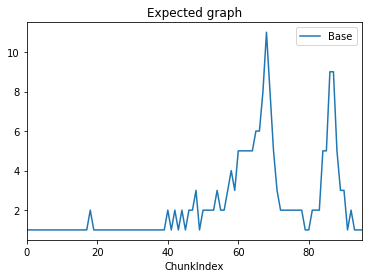

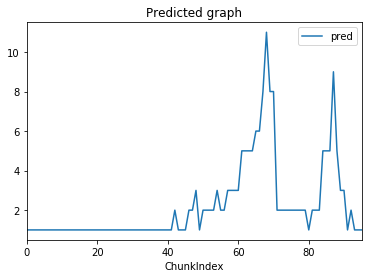

In [395]:
# VISUALIZE for only dayofweek
def visualize(clf, coordx, coordy, dayofweeknum):
    
    expect = dataset[dataset['ClusterCoordinateX']==coordx][dataset['ClusterCoordinateY']==coordy][dataset['DayOfWeekNum']==dayofweeknum].sort_values(by=['ChunkIndex'])
    if expect.empty:
        return
    test_data = np.zeros((len(expect), 4))
    
    test_data[:, 0] = len(expect)*[coordx]
    test_data[:, 1] = len(expect)*[coordy]
    test_data[:, 2] = len(expect)*[dayofweeknum]
    test_data[:, 3] = expect['ChunkIndex']
    pred = clf.predict(test_data)
    expect['pred'] = pred
    
    expect.plot(x='ChunkIndex', y='Base', title='Expected graph')
    expect.plot(x='ChunkIndex', y='pred', title='Predicted graph')
    

visualize(randf, 156, 244, 0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


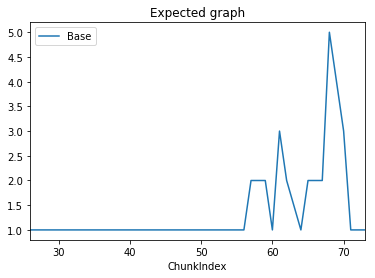

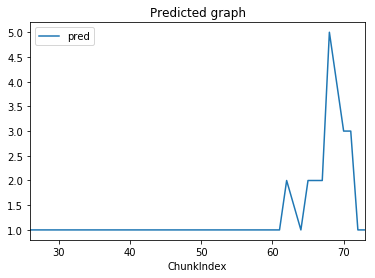

In [109]:
# example of running the model
# coordX, coordY, dayofweeknum, monthdaynum, chunkindex

# plot predicted nums, and true nums for each chunkindex

# ClusterCoordinateX	ClusterCoordinateY	DayOfWeekNum	MonthDayNum	ChunkIndex	Base
def visualize(clf, coordx, coordy, dayofweeknum, monthdaynum):
    
    expect = dataset[dataset['ClusterCoordinateX']==coordx][dataset['ClusterCoordinateY']==coordy][dataset['DayOfWeekNum']==dayofweeknum][dataset['MonthDayNum']==monthdaynum].sort_values(by=['ChunkIndex'])
    if expect.empty:
        return
    test_data = np.zeros((len(expect), 5))
    
    test_data[:, 0] = len(expect)*[coordx]
    test_data[:, 1] = len(expect)*[coordy]
    test_data[:, 2] = len(expect)*[dayofweeknum]
    test_data[:, 3] = len(expect)*[monthdaynum]
    test_data[:, 4] = expect['ChunkIndex']
    pred = clf.predict(test_data)
    expect['pred'] = pred
    
    expect.plot(x='ChunkIndex', y='Base', title='Expected graph')
    expect.plot(x='ChunkIndex', y='pred', title='Predicted graph')
    

visualize(randf, 447, 324, 0, 5)
#visualize(662, 317, 0, 18)
# visualize(653, 315, 3, 21)
#visualize(672, 369, 6, 17)

In [103]:
db = pd.read_csv('db_all_aug14box.csv')

def get_latlons_for_cluster(db, clusterX, clusterY):
    points = db[db['ClusterCoordinateX']==clusterX][db['ClusterCoordinateY']==clusterY][['Lat', 'Lon']]
    print(len(points))
    points['name'] = '[{} {}]'.format(clusterX, clusterY)
    points['color'] = '#FFFF00'
    points.to_csv('points.csv'.format(clusterX, clusterY), index=False)
    points.head()


get_latlons_for_cluster(db, 594, 406)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


38625
